<a href="https://colab.research.google.com/github/ekuelkpodar/AIAcademy/blob/main/Building_transformers_for_LLMs_with_Google_Colab_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Visualizing attention for "hello world":


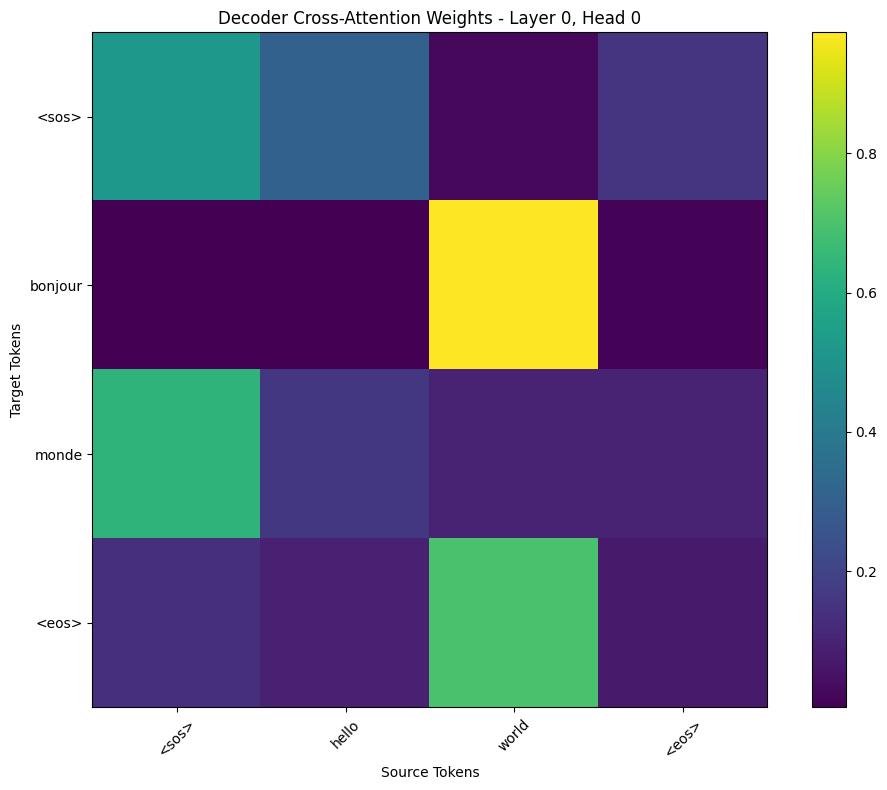

In [ ]:
print('\n' + '='*50)
print('Visualizing attention for "hello world":')
print('='*50)

visualize_attention(model, "hello world", "bonjour monde", src_vocab, tgt_vocab, device, layer_idx=0, head_idx=0)


Visualizing attention for "hello world":


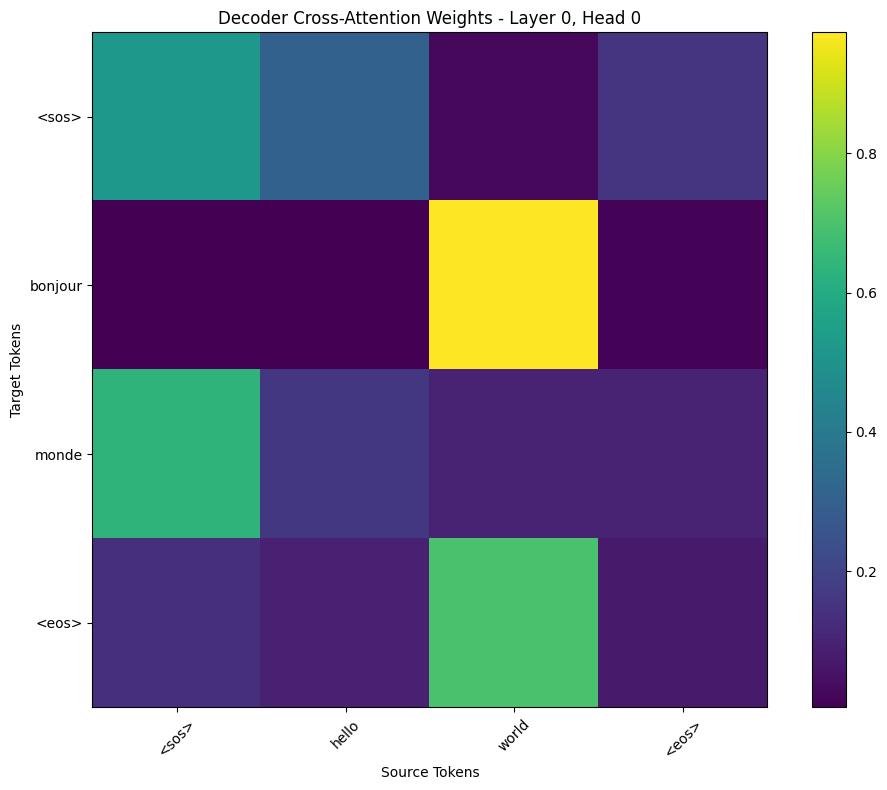

In [ ]:
print('\n' + '='*50)
print('Visualizing attention for "hello world":')
print('='*50)

visualize_attention(model, "hello world", "bonjour monde", src_vocab, tgt_vocab, device, layer_idx=0, head_idx=0)


Visualizing attention for "hello world":


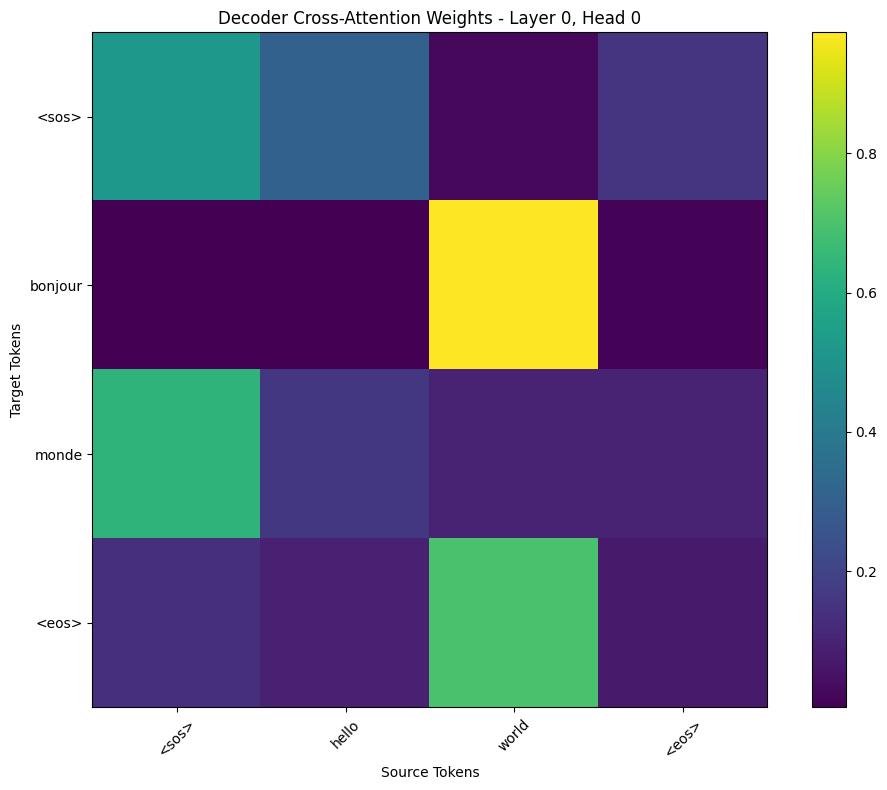

In [ ]:
print('\n' + '='*50)
print('Visualizing attention for "hello world":')
print('='*50)

visualize_attention(model, "hello world", "bonjour monde", src_vocab, tgt_vocab, device, layer_idx=0, head_idx=0)

---

## 9. Optimization Techniques

### 9.1 Learning Rate Scheduling

In [ ]:
class WarmupScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def step(self):
        self.step_num += 1
        lr = self.d_model ** (-0.5) * min(self.step_num ** (-0.5),
                                          self.step_num * self.warmup_steps ** (-1.5))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

### 9.2 Label Smoothing

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, vocab_size=None, padding_idx=0):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        """
        Args:
            pred: Predictions [batch_size * seq_len, vocab_size]
            target: Ground truth labels [batch_size * seq_len]
        """
        vocab_size = pred.size(-1)

        # Create smoothed target distribution
        smooth_target = torch.zeros_like(pred)
        smooth_target.fill_(self.smoothing / (vocab_size - 2))  # -2 for true class and padding
        smooth_target.scatter_(1, target.unsqueeze(1), self.confidence)
        smooth_target[:, self.padding_idx] = 0

        # Mask padding positions
        mask = (target != self.padding_idx).unsqueeze(1)
        smooth_target = smooth_target * mask

        # Calculate loss
        log_probs = F.log_softmax(pred, dim=-1)
        loss = -(smooth_target * log_probs).sum(dim=-1)
        loss = loss[mask.squeeze()].mean()

        return loss

### 9.3 Gradient Accumulation

In [ ]:
def train_with_accumulation(model, train_loader, criterion, optimizer, device,
                           accumulation_steps=4, num_epochs=10):
    """
    Training with gradient accumulation

    Args:
        accumulation_steps: Number of steps to accumulate gradients
    """
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        optimizer.zero_grad()

        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            # Forward pass
            output = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            # Calculate loss and normalize by accumulation steps
            loss = criterion(output, tgt_output) / accumulation_steps
            loss.backward()

            # Update weights every accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * accumulation_steps

        print(f'Epoch {epoch+1} completed. Average Loss: {total_loss/len(train_loader):.4f}')

### 9.4 Mixed Precision Training

In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_mixed_precision(model, train_loader, criterion, optimizer, device, num_epochs=10):
    """
    Training with automatic mixed precision (FP16)
    """
    model.train()
    scaler = GradScaler()

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            optimizer.zero_grad()

            # Forward pass with autocast
            with autocast():
                output = model(src, tgt_input)
                output = output.reshape(-1, output.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = criterion(output, tgt_output)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f'Epoch {epoch+1} completed. Average Loss: {total_loss/len(train_loader):.4f}')

### 9.5 Attention Visualization

In [ ]:
def visualize_attention(model, src_sentence, tgt_sentence, src_vocab, tgt_vocab,
                       device, layer_idx=0, head_idx=0):
    """
    Visualize attention weights for a specific layer and head

    Args:
        layer_idx: Which encoder/decoder layer to visualize
        head_idx: Which attention head to visualize
    """
    model.eval()

    # Encode sentences
    src_tokens = ['<sos>'] + src_sentence.lower().split() + ['<eos>']
    tgt_tokens = ['<sos>'] + tgt_sentence.lower().split() + ['<eos>']

    src_indices = torch.tensor([[src_vocab.get(t, src_vocab['<unk>']) for t in src_tokens]]).to(device)
    tgt_indices = torch.tensor([[tgt_vocab.get(t, tgt_vocab['<unk>']) for t in tgt_tokens]]).to(device)

    with torch.no_grad():
        src_mask = model.make_src_mask(src_indices)
        encoder_output, encoder_self_attention_weights = model.encode(src_indices, src_mask)

        # To visualize cross-attention, we need decoder output too.
        # The decode function expects a target input. We'll use the full target sentence for visualization.
        tgt_mask = model.make_tgt_mask(tgt_indices)
        _, decoder_self_attention_weights, decoder_cross_attention_weights = \
            model.decode(tgt_indices, encoder_output, src_mask, tgt_mask)

        # Determine which attention weights to visualize based on layer_idx.
        # For simplicity, we'll focus on visualizing decoder cross-attention weights, as they show source-target alignment.
        # The weights are of shape [batch_size, num_heads, tgt_seq_len, src_seq_len]
        if layer_idx < len(decoder_cross_attention_weights):
            attention_weights = decoder_cross_attention_weights[layer_idx] # Shape: [1, num_heads, tgt_len, src_len]
            if head_idx < attention_weights.shape[1]:
                attention_weights = attention_weights.squeeze(0)[head_idx].cpu().numpy() # Shape: [tgt_len, src_len]
                title = f'Decoder Cross-Attention Weights - Layer {layer_idx}, Head {head_idx}'
            else:
                print(f"Warning: head_idx {head_idx} out of range for layer {layer_idx}. Defaulting to head 0.")
                attention_weights = attention_weights.squeeze(0)[0].cpu().numpy()
                title = f'Decoder Cross-Attention Weights - Layer {layer_idx}, Head 0 (Default)'
        else:
            print(f"Warning: layer_idx {layer_idx} out of range for decoder cross-attention layers. Defaulting to first layer/head if available.")
            if decoder_cross_attention_weights:
                attention_weights = decoder_cross_attention_weights[0].squeeze(0)[0].cpu().numpy()
                title = 'Decoder Cross-Attention Weights - Layer 0, Head 0 (Default)'
            else:
                print("No decoder cross-attention weights available.")
                plt.text(0.5, 0.5, "No Attention Weights to Display", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title('Attention Visualization (No Weights)')
                plt.show()
                return

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_weights, cmap='viridis')
    plt.xlabel('Source Tokens')
    plt.ylabel('Target Tokens')
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45)
    plt.yticks(range(len(tgt_tokens)), tgt_tokens)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

---

## 10. Advanced Techniques for Scaling to LLMs

### 10.1 Decoder-Only Architecture (GPT-style)

In [ ]:
class GPTTransformer(nn.Module):
    """
    Decoder-only transformer (GPT-style) for language modeling
    """
    def __init__(self, vocab_size, d_model=768, num_heads=12, num_layers=12,
                 d_ff=3072, max_seq_len=1024, dropout=0.1):
        super(GPTTransformer, self).__init__()

        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        # Decoder layers only (no encoder)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len = x.shape

        # Create causal mask
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        mask = mask.to(x.device)

        # Embed and add positional encoding
        x = self.token_embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask)

        x = self.ln_f(x)
        logits = self.fc_out(x)

        return logits

class DecoderBlock(nn.Module):
    """Single decoder block for GPT-style models"""
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Self-attention with causal mask
        attn_output, _ = self.self_attn(x, x, x, mask.unsqueeze(0).unsqueeze(0))
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x

### 10.2 Rotary Position Embeddings (RoPE)

In [ ]:
class RotaryPositionalEmbedding(nn.Module):
    """
    Rotary Position Embedding (RoPE) as used in models like LLaMA
    """
    def __init__(self, dim, max_seq_len=2048, base=10000):
        super(RotaryPositionalEmbedding, self).__init__()

        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self.max_seq_len = max_seq_len

    def forward(self, x, seq_len):
        """
        Args:
            x: Input tensor [batch, seq_len, num_heads, head_dim]
            seq_len: Sequence length
        """
        t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)

        return emb.cos()[None, :, None, :], emb.sin()[None, :, None, :]

def apply_rotary_emb(x, cos, sin):
    """Apply rotary embeddings to input tensor"""
    x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
    return torch.cat([
        x1 * cos - x2 * sin,
        x1 * sin + x2 * cos
    ], dim=-1)

### 10.3 Key-Value Caching for Inference

In [ ]:
def generate_with_cache(model, prompt_ids, max_new_tokens=50, temperature=1.0, top_k=50):
    """
    Generate text with KV caching for efficient inference

    Args:
        model: GPT-style transformer model
        prompt_ids: Input token IDs [1, prompt_len]
        max_new_tokens: Number of tokens to generate
        temperature: Sampling temperature
        top_k: Top-k sampling parameter
    """
    model.eval()

    input_ids = prompt_ids
    past_key_values = None

    for _ in range(max_new_tokens):
        with torch.no_grad():
            # Forward pass (with caching in production models)
            outputs = model(input_ids)
            logits = outputs[:, -1, :] / temperature

            # Top-k filtering
            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits[indices_to_remove] = float('-inf')

            # Sample next token
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)

    return input_ids

---

## 11. Best Practices and Tips

### Memory Optimization
1. **Gradient Checkpointing**: Trade compute for memory
2. **Mixed Precision**: Use FP16 for faster training
3. **Batch Size Tuning**: Find optimal batch size for your GPU
4. **Gradient Accumulation**: Simulate larger batches

### Training Stability
1. **Layer Normalization**: Use pre-norm (before attention) for deeper models
2. **Gradient Clipping**: Prevent exploding gradients
3. **Warmup**: Gradually increase learning rate
4. **Weight Initialization**: Use Xavier or He initialization

### Hyperparameter Recommendations
```python
# Small model (testing)
d_model = 256
num_heads = 4
num_layers = 4
d_ff = 1024

# Medium model (GPT-2 small)
d_model = 768
num_heads = 12
num_layers = 12
d_ff = 3072

# Large model (GPT-2 large)
d_model = 1280
num_heads = 20
num_layers = 36
d_ff = 5120
```

---

## 12. Common Issues and Solutions

### Issue 1: Out of Memory
**Solutions:**
- Reduce batch size
- Use gradient accumulation
- Enable mixed precision training
- Use gradient checkpointing

### Issue 2: Loss Not Decreasing
**Solutions:**
- Check learning rate (try 1e-4 to 1e-3)
- Verify data preprocessing
- Check for gradient clipping
- Ensure masks are correct

### Issue 3: Poor Generation Quality
**Solutions:**
- Train longer
- Increase model size
- Use better tokenization
- Implement beam search instead of greedy decoding

---

## 13. Further Reading and Resources

### Papers
1. **"Attention Is All You Need"** (Vaswani et al., 2017) - Original transformer paper
2. **"BERT"** (Devlin et al., 2018) - Bidirectional transformers
3. **"GPT-2"** (Radford et al., 2019) - Language models are unsupervised multitask learners
4. **"GPT-3"** (Brown et al., 2020) - Few-shot learning with large models

### Online Resources
- Annotated Transformer: http://nlp.seas.harvard.edu/annotated-transformer/
- Hugging Face Transformers: https://huggingface.co/docs/transformers/
- PyTorch Tutorials: https://pytorch.org/tutorials/

### Next Steps
1. Implement attention visualization
2. Add beam search decoding
3. Experiment with different positional encodings
4. Train on larger datasets (WMT, WikiText)
5. Implement model parallelism for very large models

---

## Conclusion

This guide provides a complete foundation for understanding and implementing transformers. The architecture you've built here is the same fundamental design powering modern LLMs, just at different scales. To scale to production LLMs:

1. **Scale up**: More layers, larger dimensions, more data
2. **Optimize**: Use efficient attention variants (FlashAttention)
3. **Distribute**: Model and data parallelism across GPUs
4. **Fine-tune**: Instruction tuning, RLHF for alignment

Happy building! 🚀

---

## 10. Advanced Techniques for Scaling to LLMs

### 10.1 Decoder-Only Architecture (GPT-style)

In [ ]:
class GPTTransformer(nn.Module):
    """
    Decoder-only transformer (GPT-style) for language modeling
    """
    def __init__(self, vocab_size, d_model=768, num_heads=12, num_layers=12,
                 d_ff=3072, max_seq_len=1024, dropout=0.1):
        super(GPTTransformer, self).__init__()

        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        # Decoder layers only (no encoder)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len = x.shape

        # Create causal mask
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        mask = mask.to(x.device)

        # Embed and add positional encoding
        x = self.token_embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask)

        x = self.ln_f(x)
        logits = self.fc_out(x)

        return logits

class DecoderBlock(nn.Module):
    """Single decoder block for GPT-style models"""
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Self-attention with causal mask
        attn_output, _ = self.self_attn(x, x, x, mask.unsqueeze(0).unsqueeze(0))
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x

### 10.2 Rotary Position Embeddings (RoPE)

In [ ]:
class RotaryPositionalEmbedding(nn.Module):
    """
    Rotary Position Embedding (RoPE) as used in models like LLaMA
    """
    def __init__(self, dim, max_seq_len=2048, base=10000):
        super(RotaryPositionalEmbedding, self).__init__()

        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self.max_seq_len = max_seq_len

    def forward(self, x, seq_len):
        """
        Args:
            x: Input tensor [batch, seq_len, num_heads, head_dim]
            seq_len: Sequence length
        """
        t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)

        return emb.cos()[None, :, None, :], emb.sin()[None, :, None, :]

def apply_rotary_emb(x, cos, sin):
    """Apply rotary embeddings to input tensor"""
    x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
    return torch.cat([
        x1 * cos - x2 * sin,
        x1 * sin + x2 * cos
    ], dim=-1)

### 10.3 Key-Value Caching for Inference

In [ ]:
def generate_with_cache(model, prompt_ids, max_new_tokens=50, temperature=1.0, top_k=50):
    """
    Generate text with KV caching for efficient inference

    Args:
        model: GPT-style transformer model
        prompt_ids: Input token IDs [1, prompt_len]
        max_new_tokens: Number of tokens to generate
        temperature: Sampling temperature
        top_k: Top-k sampling parameter
    """
    model.eval()

    input_ids = prompt_ids
    past_key_values = None

    for _ in range(max_new_tokens):
        with torch.no_grad():
            # Forward pass (with caching in production models)
            outputs = model(input_ids)
            logits = outputs[:, -1, :] / temperature

            # Top-k filtering
            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits[indices_to_remove] = float('-inf')

            # Sample next token
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)

    return input_ids

---

## 11. Best Practices and Tips

### Memory Optimization
1. **Gradient Checkpointing**: Trade compute for memory
2. **Mixed Precision**: Use FP16 for faster training
3. **Batch Size Tuning**: Find optimal batch size for your GPU
4. **Gradient Accumulation**: Simulate larger batches

### Training Stability
1. **Layer Normalization**: Use pre-norm (before attention) for deeper models
2. **Gradient Clipping**: Prevent exploding gradients
3. **Warmup**: Gradually increase learning rate
4. **Weight Initialization**: Use Xavier or He initialization

### Hyperparameter Recommendations
```python
# Small model (testing)
d_model = 256
num_heads = 4
num_layers = 4
d_ff = 1024

# Medium model (GPT-2 small)
d_model = 768
num_heads = 12
num_layers = 12
d_ff = 3072

# Large model (GPT-2 large)
d_model = 1280
num_heads = 20
num_layers = 36
d_ff = 5120
```

---

## 12. Common Issues and Solutions

### Issue 1: Out of Memory
**Solutions:**
- Reduce batch size
- Use gradient accumulation
- Enable mixed precision training
- Use gradient checkpointing

### Issue 2: Loss Not Decreasing
**Solutions:**
- Check learning rate (try 1e-4 to 1e-3)
- Verify data preprocessing
- Check for gradient clipping
- Ensure masks are correct

### Issue 3: Poor Generation Quality
**Solutions:**
- Train longer
- Increase model size
- Use better tokenization
- Implement beam search instead of greedy decoding

---

## 13. Further Reading and Resources

### Papers
1. **"Attention Is All You Need"** (Vaswani et al., 2017) - Original transformer paper
2. **"BERT"** (Devlin et al., 2018) - Bidirectional transformers
3. **"GPT-2"** (Radford et al., 2019) - Language models are unsupervised multitask learners
4. **"GPT-3"** (Brown et al., 2020) - Few-shot learning with large models

### Online Resources
- Annotated Transformer: http://nlp.seas.harvard.edu/annotated-transformer/
- Hugging Face Transformers: https://huggingface.co/docs/transformers/
- PyTorch Tutorials: https://pytorch.org/tutorials/

### Next Steps
1. Implement attention visualization
2. Add beam search decoding
3. Experiment with different positional encodings
4. Train on larger datasets (WMT, WikiText)
5. Implement model parallelism for very large models

---

## Conclusion

This guide provides a complete foundation for understanding and implementing transformers. The architecture you've built here is the same fundamental design powering modern LLMs, just at different scales. To scale to production LLMs:

1. **Scale up**: More layers, larger dimensions, more data
2. **Optimize**: Use efficient attention variants (FlashAttention)
3. **Distribute**: Model and data parallelism across GPUs
4. **Fine-tune**: Instruction tuning, RLHF for alignment

Happy building! 🚀

# Building Transformers That Power Large Language Models: A Comprehensive Guide

## Table of Contents
1. Introduction to Transformers
2. Core Architecture Components
3. Mathematical Foundations
4. Implementation Strategy
5. Google Colab Setup
6. Complete Code Implementation
7. Training and Evaluation
8. Optimization Techniques
9. Advanced Techniques for Scaling to LLMs
10. Best Practices and Tips
11. Common Issues and Solutions
12. Further Reading and Resources

---

## 1. Introduction to Transformers

Transformers are the foundational architecture behind modern large language models (LLMs) like GPT, BERT, and Claude. Introduced in the 2017 paper "Attention Is All You Need" by Vaswani et al., transformers revolutionized natural language processing by replacing recurrent architectures with attention mechanisms.

### Key Innovation
The transformer's core innovation is the **self-attention mechanism**, which allows the model to weigh the importance of different words in a sequence when processing each word, enabling parallel processing and capturing long-range dependencies.

---

## 2. Core Architecture Components

### 2.1 Multi-Head Self-Attention
The attention mechanism computes relationships between all positions in a sequence simultaneously.

**Mathematical Formula:**
```
Attention(Q, K, V) = softmax(QK^T / √d_k)V
```

Where:
- Q (Query): What we're looking for
- K (Key): What we have
- V (Value): The actual content
- d_k: Dimension of key vectors (for scaling)

**Multi-head attention** runs multiple attention operations in parallel, allowing the model to attend to different aspects of the input.

### 2.2 Position-wise Feed-Forward Networks
After attention, each position passes through a two-layer fully-connected network independently:

```
FFN(x) = max(0, xW1 + b1)W2 + b2
```

This adds non-linearity and allows the model to process attended information.

### 2.3 Positional Encoding
Since transformers process all tokens in parallel, we need to inject position information:

```
PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
```

### 2.4 Layer Normalization and Residual Connections
Each sub-layer uses residual connections followed by layer normalization:

```
LayerNorm(x + Sublayer(x))
```

This stabilizes training and enables deeper networks.

---

## 3. Mathematical Foundations

### 3.1 Scaled Dot-Product Attention

The attention score between query q and key k is computed as:

```
score = (q · k) / √d_k
```

Scaling by √d_k prevents gradients from becoming too small when d_k is large.

### 3.2 Softmax for Attention Weights

```
attention_weights = softmax(scores) = exp(scores_i) / Σ exp(scores_j)
```

This converts scores into a probability distribution.

### 3.3 Multi-Head Mechanism

Instead of one attention function with d_model dimensions, we use h parallel attention heads:

```
MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O

where head_i = Attention(QW^Q_i, KW^K_i, VW^V_i)
```

---

## 4. Implementation Strategy

### Building Blocks Hierarchy:
1. **Positional Encoding**: Add position information
2. **Scaled Dot-Product Attention**: Core attention mechanism
3. **Multi-Head Attention**: Multiple parallel attention operations
4. **Feed-Forward Network**: Position-wise processing
5. **Encoder Layer**: Attention + FFN with residual connections
6. **Decoder Layer**: Masked attention + cross-attention + FFN
7. **Full Transformer**: Stack of encoder and decoder layers

---

## 5. Google Colab Setup

### Step 1: Open Google Colab
Navigate to [colab.research.google.com](https://colab.research.google.com)

### Step 2: Enable GPU (Recommended)
- Runtime → Change runtime type → Hardware accelerator → GPU → Save

### Step 3: Install Required Libraries
Most libraries are pre-installed, but ensure you have the latest versions.

---

## 6. Complete Code Implementation

### 6.1 Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

### 6.2 Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model: Embedding dimension
            max_len: Maximum sequence length
        """
        super(PositionalEncoding, self).__init__()

        # Create matrix of [max_len, d_model] representing positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute the div_term for sine and cosine functions
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension
        pe = pe.unsqueeze(0)

        # Register as buffer (not a parameter, but should be saved in state_dict)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [batch_size, seq_len, d_model]
        """
        # Add positional encoding to input
        x = x + self.pe[:, :x.size(1), :]
        return x

### 6.3 Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        """
        Args:
            d_model: Dimension of model (embedding dimension)
            num_heads: Number of attention heads
            dropout: Dropout probability
        """
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Output projection
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Args:
            Q: Queries [batch_size, num_heads, seq_len, d_k]
            K: Keys [batch_size, num_heads, seq_len, d_k]
            V: Values [batch_size, num_heads, seq_len, d_k]
            mask: Optional mask [batch_size, 1, 1, seq_len] or [batch_size, 1, seq_len, seq_len]
        """
        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to values
        output = torch.matmul(attention_weights, V)

        return output, attention_weights

    def split_heads(self, x):
        """
        Split the last dimension into (num_heads, d_k)
        Args:
            x: [batch_size, seq_len, d_model]
        Returns:
            [batch_size, num_heads, seq_len, d_k]
        """
        batch_size, seq_len, d_model = x.size()
        return x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        """
        Combine the heads back
        Args:
            x: [batch_size, num_heads, seq_len, d_k]
        Returns:
            [batch_size, seq_len, d_model]
        """
        batch_size, num_heads, seq_len, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

    def forward(self, Q, K, V, mask=None):
        """
        Args:
            Q: Query [batch_size, seq_len, d_model]
            K: Key [batch_size, seq_len, d_model]
            V: Value [batch_size, seq_len, d_model]
            mask: Optional mask
        """
        # Linear projections
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)

        # Split into multiple heads
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        # Apply attention
        attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads
        output = self.combine_heads(attn_output)

        # Final linear projection
        output = self.W_o(output)

        return output, attn_weights

### 6.4 Position-wise Feed-Forward Network

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        Args:
            d_model: Model dimension
            d_ff: Hidden dimension of feed-forward network (usually 4 * d_model)
            dropout: Dropout probability
        """
        super(PositionWiseFeedForward, self).__init__()

        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len, d_model]
        """
        # First linear transformation with ReLU activation
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second linear transformation
        x = self.fc2(x)

        return x

### 6.5 Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Single encoder layer with self-attention and feed-forward network

        Args:
            d_model: Model dimension
            num_heads: Number of attention heads
            d_ff: Feed-forward hidden dimension
            dropout: Dropout probability
        """
        super(EncoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Args:
            x: Input [batch_size, seq_len, d_model]
            mask: Optional attention mask
        """
        # Self-attention with residual connection and layer norm
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x, attn_weights

### 6.6 Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Single decoder layer with masked self-attention, cross-attention, and feed-forward

        Args:
            d_model: Model dimension
            num_heads: Number of attention heads
            d_ff: Feed-forward hidden dimension
            dropout: Dropout probability
        """
        super(DecoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: Decoder input [batch_size, tgt_seq_len, d_model]
            encoder_output: Encoder output [batch_size, src_seq_len, d_model]
            src_mask: Source mask for encoder output
            tgt_mask: Target mask (causal mask) for decoder
        """
        # Masked self-attention
        self_attn_output, self_attn_weights = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(self_attn_output))

        # Cross-attention to encoder output
        cross_attn_output, cross_attn_weights = self.cross_attn(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout2(cross_attn_output))

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))

        return x, self_attn_weights, cross_attn_weights

### 6.7 Complete Transformer Model

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8,
                 num_encoder_layers=6, num_decoder_layers=6, d_ff=2048,
                 max_seq_len=5000, dropout=0.1):
        """
        Complete Transformer model

        Args:
            src_vocab_size: Source vocabulary size
            tgt_vocab_size: Target vocabulary size
            d_model: Model dimension
            num_heads: Number of attention heads
            num_encoder_layers: Number of encoder layers
            num_decoder_layers: Number of decoder layers
            d_ff: Feed-forward hidden dimension
            max_seq_len: Maximum sequence length
            dropout: Dropout probability
        """
        super(Transformer, self).__init__()

        self.d_model = d_model

        # Embedding layers
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])

        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])

        # Output projection
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier uniform initialization"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz):
        """
        Generate causal mask for decoder (prevents attending to future positions)

        Args:
            sz: Sequence length
        Returns:
            Mask of shape [sz, sz]
        """
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_src_mask(self, src):
        """
        Create mask for source sequence (mask padding tokens)

        Args:
            src: Source tensor [batch_size, src_seq_len]
        Returns:
            Mask [batch_size, 1, 1, src_seq_len]
        """
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_tgt_mask(self, tgt):
        """
        Create mask for target sequence (causal mask + padding mask)

        Args:
            tgt: Target tensor [batch_size, tgt_seq_len]
        Returns:
            Mask [batch_size, 1, tgt_seq_len, tgt_seq_len]
        """
        batch_size, tgt_len = tgt.shape

        # Padding mask
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)

        # Causal mask
        tgt_sub_mask = self.generate_square_subsequent_mask(tgt_len).to(tgt.device)
        tgt_sub_mask = tgt_sub_mask.unsqueeze(0)

        # Combine masks
        tgt_mask = tgt_pad_mask & (tgt_sub_mask == 0)

        return tgt_mask

    def encode(self, src, src_mask):
        """
        Encode source sequence

        Args:
            src: Source tensor [batch_size, src_seq_len]
            src_mask: Source mask
        Returns:
            Encoder output [batch_size, src_seq_len, d_model]
        """
        # Embedding + positional encoding
        x = self.src_embedding(src) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        encoder_self_attention_weights = []

        # Pass through encoder layers
        for layer in self.encoder_layers:
            x, attn_weights = layer(x, src_mask)
            encoder_self_attention_weights.append(attn_weights)

        return x, encoder_self_attention_weights

    def decode(self, tgt, encoder_output, src_mask, tgt_mask):
        """
        Decode target sequence

        Args:
            tgt: Target tensor [batch_size, tgt_seq_len]
            encoder_output: Output from encoder
            src_mask: Source mask
            tgt_mask: Target mask
        Returns:
            Decoder output [batch_size, tgt_seq_len, d_model]
        """
        # Embedding + positional encoding
        x = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        decoder_self_attention_weights = []
        decoder_cross_attention_weights = []

        # Pass through decoder layers
        for layer in self.decoder_layers:
            x, self_attn_weights, cross_attn_weights = layer(x, encoder_output, src_mask, tgt_mask)
            decoder_self_attention_weights.append(self_attn_weights)
            decoder_cross_attention_weights.append(cross_attn_weights)

        return x, decoder_self_attention_weights, decoder_cross_attention_weights

    def forward(self, src, tgt):
        """
        Forward pass through the transformer

        Args:
            src: Source tensor [batch_size, src_seq_len]
            tgt: Target tensor [batch_size, tgt_seq_len]
        Returns:
            Output logits [batch_size, tgt_seq_len, tgt_vocab_size]
        """
        # Create masks
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        # Encode
        encoder_output, _ = self.encode(src, src_mask)

        # Decode
        decoder_output, _, _ = self.decode(tgt, encoder_output, src_mask, tgt_mask)

        # Project to vocabulary
        output = self.fc_out(decoder_output)

        return output

---

## 7. Training and Evaluation

### 7.1 Sample Dataset (Translation Task)

In [ ]:
class TranslationDataset(Dataset):
    """Simple dataset for sequence-to-sequence translation"""
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len=50):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = self.encode_sentence(self.src_sentences[idx], self.src_vocab)
        tgt = self.encode_sentence(self.tgt_sentences[idx], self.tgt_vocab)
        return torch.tensor(src), torch.tensor(tgt)

    def encode_sentence(self, sentence, vocab):
        """Convert sentence to token indices"""
        tokens = sentence.lower().split()
        indices = [vocab.get(token, vocab['<unk>']) for token in tokens]
        indices = [vocab['<sos>']] + indices + [vocab['<eos>']]

        # Pad or truncate
        if len(indices) < self.max_len:
            indices += [vocab['<pad>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]

        return indices

# Create simple vocabularies
def create_vocab(sentences):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    idx = 4
    for sentence in sentences:
        for word in sentence.lower().split():
            if word not in vocab:
                vocab[word] = idx
                idx += 1
    return vocab

### 7.2 Training Loop

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    """
    Training loop for the transformer model

    Args:
        model: Transformer model
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on (cuda/cpu)
        num_epochs: Number of training epochs
    """
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)

            # Target input and output for teacher forcing
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            # Forward pass
            optimizer.zero_grad()
            # The forward method of Transformer now returns attention weights, but train_model only needs the output.
            # The Transformer.forward method already ignores the attention weights it gets from encode/decode, so no change needed here.
            output = model(src, tgt_input)

            # Calculate loss
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}\n')

### 7.3 Inference Function

In [ ]:
def translate(model, src_sentence, src_vocab, tgt_vocab, device, max_len=50):
    """
    Translate a source sentence using the trained model

    Args:
        model: Trained transformer model
        src_sentence: Source sentence string
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        device: Device
        max_len: Maximum generation length
    Returns:
        Translated sentence
    """
    model.eval()

    # Encode source sentence
    src_tokens = src_sentence.lower().split()
    src_indices = [src_vocab['<sos>']] + [src_vocab.get(t, src_vocab['<unk>']) for t in src_tokens] + [src_vocab['<eos>']]
    src_tensor = torch.tensor(src_indices).unsqueeze(0).to(device)

    # Create reverse vocabulary for target
    idx_to_word = {idx: word for word, idx in tgt_vocab.items()}

    # Start with <sos> token
    tgt_indices = [tgt_vocab['<sos>']]

    with torch.no_grad():
        # Encode source
        encoder_output, _ = model.encode(src_tensor, src_mask=model.make_src_mask(src_tensor)) # Modified to unpack attention weights

        # Generate tokens one by one
        for _ in range(max_len):
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            tgt_mask = model.make_tgt_mask(tgt_tensor)

            # Decode
            decoder_output, _, _ = model.decode(tgt_tensor, encoder_output, src_mask=model.make_src_mask(src_tensor), tgt_mask=tgt_mask) # Modified to unpack attention weights
            output = model.fc_out(decoder_output)

            # Get next token
            next_token = output.argmax(dim=-1)[:, -1].item()
            tgt_indices.append(next_token)

            # Stop if we generate <eos>
            if next_token == tgt_vocab['<eos>']:
                break

    # Convert indices to words
    translated = [idx_to_word.get(idx, '<unk>') for idx in tgt_indices[1:-1]]

    return ' '.join(translated)

---

## 8. Complete Google Colab Example

In [ ]:
# ==========================
# COMPLETE COLAB IMPLEMENTATION
# ==========================

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Sample data (English to French translation - toy example)
src_sentences = [
    'hello world',
    'how are you',
    'good morning',
    'thank you very much',
    'see you later',
]

tgt_sentences = [
    'bonjour monde',
    'comment allez vous',
    'bonjour',
    'merci beaucoup',
    'a bientot',
]

# Create vocabularies
src_vocab = create_vocab(src_sentences)
tgt_vocab = create_vocab(tgt_sentences)

print(f'Source vocab size: {len(src_vocab)}')
print(f'Target vocab size: {len(tgt_vocab)}')

# Create dataset and dataloader
dataset = TranslationDataset(src_sentences, tgt_sentences, src_vocab, tgt_vocab)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Initialize model
model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    d_model=128,
    num_heads=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    d_ff=512,
    max_seq_len=50,
    dropout=0.1
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Train the model
print('\nStarting training...\n')
train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

# Test translation
print('\n' + '='*50)
print('Testing translations:')
print('='*50)

test_sentences = ['hello world', 'thank you very much']
for sentence in test_sentences:
    translation = translate(model, sentence, src_vocab, tgt_vocab, device)
    print(f'Input: {sentence}')
    print(f'Translation: {translation}\n')

Using device: cpu
Source vocab size: 16
Target vocab size: 13
Total parameters: 931,085

Starting training...

Epoch: 1/100, Batch: 0, Loss: 3.0073
Epoch 1 completed. Average Loss: 2.7655

Epoch: 2/100, Batch: 0, Loss: 2.7612
Epoch 2 completed. Average Loss: 2.4522

Epoch: 3/100, Batch: 0, Loss: 2.4198
Epoch 3 completed. Average Loss: 2.1736

Epoch: 4/100, Batch: 0, Loss: 2.5419
Epoch 4 completed. Average Loss: 2.0651

Epoch: 5/100, Batch: 0, Loss: 1.6011
Epoch 5 completed. Average Loss: 1.9731

Epoch: 6/100, Batch: 0, Loss: 1.6142
Epoch 6 completed. Average Loss: 1.8440

Epoch: 7/100, Batch: 0, Loss: 2.1556
Epoch 7 completed. Average Loss: 1.9361

Epoch: 8/100, Batch: 0, Loss: 1.1978
Epoch 8 completed. Average Loss: 1.5961

Epoch: 9/100, Batch: 0, Loss: 1.5651
Epoch 9 completed. Average Loss: 1.2369

Epoch: 10/100, Batch: 0, Loss: 1.5831
Epoch 10 completed. Average Loss: 1.6639

Epoch: 11/100, Batch: 0, Loss: 1.8198
Epoch 11 completed. Average Loss: 1.5448

Epoch: 12/100, Batch: 0, Lo

---

## 9. Optimization Techniques

### 9.1 Learning Rate Scheduling

In [ ]:
class WarmupScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def step(self):
        self.step_num += 1
        lr = self.d_model ** (-0.5) * min(self.step_num ** (-0.5),
                                          self.step_num * self.warmup_steps ** (-1.5))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

### 9.2 Label Smoothing

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, vocab_size=None, padding_idx=0):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        """
        Args:
            pred: Predictions [batch_size * seq_len, vocab_size]
            target: Ground truth labels [batch_size * seq_len]
        """
        vocab_size = pred.size(-1)

        # Create smoothed target distribution
        smooth_target = torch.zeros_like(pred)
        smooth_target.fill_(self.smoothing / (vocab_size - 2))  # -2 for true class and padding
        smooth_target.scatter_(1, target.unsqueeze(1), self.confidence)
        smooth_target[:, self.padding_idx] = 0

        # Mask padding positions
        mask = (target != self.padding_idx).unsqueeze(1)
        smooth_target = smooth_target * mask

        # Calculate loss
        log_probs = F.log_softmax(pred, dim=-1)
        loss = -(smooth_target * log_probs).sum(dim=-1)
        loss = loss[mask.squeeze()].mean()

        return loss

### 9.3 Gradient Accumulation

In [ ]:
def train_with_accumulation(model, train_loader, criterion, optimizer, device,
                           accumulation_steps=4, num_epochs=10):
    """
    Training with gradient accumulation

    Args:
        accumulation_steps: Number of steps to accumulate gradients
    """
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        optimizer.zero_grad()

        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            # Forward pass
            output = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            # Calculate loss and normalize by accumulation steps
            loss = criterion(output, tgt_output) / accumulation_steps
            loss.backward()

            # Update weights every accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * accumulation_steps

        print(f'Epoch {epoch+1} completed. Average Loss: {total_loss/len(train_loader):.4f}')

### 9.4 Mixed Precision Training

In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_mixed_precision(model, train_loader, criterion, optimizer, device, num_epochs=10):
    """
    Training with automatic mixed precision (FP16)
    """
    model.train()
    scaler = GradScaler()

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            optimizer.zero_grad()

            # Forward pass with autocast
            with autocast():
                output = model(src, tgt_input)
                output = output.reshape(-1, output.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = criterion(output, tgt_output)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f'Epoch {epoch+1} completed. Average Loss: {total_loss/len(train_loader):.4f}')

### 9.5 Attention Visualization

In [ ]:
def visualize_attention(model, src_sentence, tgt_sentence, src_vocab, tgt_vocab,
                       device, layer_idx=0, head_idx=0):
    """
    Visualize attention weights for a specific layer and head

    Args:
        layer_idx: Which encoder/decoder layer to visualize
        head_idx: Which attention head to visualize
    """
    model.eval()

    # Encode sentences
    src_tokens = ['<sos>'] + src_sentence.lower().split() + ['<eos>']
    tgt_tokens = ['<sos>'] + tgt_sentence.lower().split() + ['<eos>']

    src_indices = torch.tensor([[src_vocab.get(t, src_vocab['<unk>']) for t in src_tokens]]).to(device)
    tgt_indices = torch.tensor([[tgt_vocab.get(t, tgt_vocab['<unk>']) for t in tgt_tokens]]).to(device)

    with torch.no_grad():
        # Get attention weights from a specific layer
        src_mask = model.make_src_mask(src_indices)
        encoder_output = model.encode(src_indices, src_mask)

        # Extract attention from specific layer and head
        tgt_mask = model.make_tgt_mask(tgt_indices)

        # For visualization, we'd need to modify the forward pass to return attention weights
        # This is a simplified version

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    # attention_weights would be extracted from the model
    # plt.imshow(attention_weights, cmap='viridis')
    plt.xlabel('Source Tokens')
    plt.ylabel('Target Tokens')
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45)
    plt.yticks(range(len(tgt_tokens)), tgt_tokens)
    plt.colorbar()
    plt.title(f'Attention Weights - Layer {layer_idx}, Head {head_idx}')
    plt.tight_layout()
    plt.show()

---

## 10. Advanced Techniques for Scaling to LLMs

### 10.1 Decoder-Only Architecture (GPT-style)

In [ ]:
class GPTTransformer(nn.Module):
    """
    Decoder-only transformer (GPT-style) for language modeling
    """
    def __init__(self, vocab_size, d_model=768, num_heads=12, num_layers=12,
                 d_ff=3072, max_seq_len=1024, dropout=0.1):
        super(GPTTransformer, self).__init__()

        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        # Decoder layers only (no encoder)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len = x.shape

        # Create causal mask
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        mask = mask.to(x.device)

        # Embed and add positional encoding
        x = self.token_embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask)

        x = self.ln_f(x)
        logits = self.fc_out(x)

        return logits

class DecoderBlock(nn.Module):
    """Single decoder block for GPT-style models"""
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Self-attention with causal mask
        attn_output, _ = self.self_attn(x, x, x, mask.unsqueeze(0).unsqueeze(0))
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x

### 10.2 Rotary Position Embeddings (RoPE)

In [ ]:
class RotaryPositionalEmbedding(nn.Module):
    """
    Rotary Position Embedding (RoPE) as used in models like LLaMA
    """
    def __init__(self, dim, max_seq_len=2048, base=10000):
        super(RotaryPositionalEmbedding, self).__init__()

        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self.max_seq_len = max_seq_len

    def forward(self, x, seq_len):
        """
        Args:
            x: Input tensor [batch, seq_len, num_heads, head_dim]
            seq_len: Sequence length
        """
        t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)

        return emb.cos()[None, :, None, :], emb.sin()[None, :, None, :]

def apply_rotary_emb(x, cos, sin):
    """Apply rotary embeddings to input tensor"""
    x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
    return torch.cat([
        x1 * cos - x2 * sin,
        x1 * sin + x2 * cos
    ], dim=-1)

### 10.3 Key-Value Caching for Inference

In [ ]:
def generate_with_cache(model, prompt_ids, max_new_tokens=50, temperature=1.0, top_k=50):
    """
    Generate text with KV caching for efficient inference

    Args:
        model: GPT-style transformer model
        prompt_ids: Input token IDs [1, prompt_len]
        max_new_tokens: Number of tokens to generate
        temperature: Sampling temperature
        top_k: Top-k sampling parameter
    """
    model.eval()

    input_ids = prompt_ids
    past_key_values = None

    for _ in range(max_new_tokens):
        with torch.no_grad():
            # Forward pass (with caching in production models)
            outputs = model(input_ids)
            logits = outputs[:, -1, :] / temperature

            # Top-k filtering
            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits[indices_to_remove] = float('-inf')

            # Sample next token
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)

    return input_ids

---

## 11. Best Practices and Tips

### Memory Optimization
1. **Gradient Checkpointing**: Trade compute for memory
2. **Mixed Precision**: Use FP16 for faster training
3. **Batch Size Tuning**: Find optimal batch size for your GPU
4. **Gradient Accumulation**: Simulate larger batches

### Training Stability
1. **Layer Normalization**: Use pre-norm (before attention) for deeper models
2. **Gradient Clipping**: Prevent exploding gradients
3. **Warmup**: Gradually increase learning rate
4. **Weight Initialization**: Use Xavier or He initialization

### Hyperparameter Recommendations
```python
# Small model (testing)
d_model = 256
num_heads = 4
num_layers = 4
d_ff = 1024

# Medium model (GPT-2 small)
d_model = 768
num_heads = 12
num_layers = 12
d_ff = 3072

# Large model (GPT-2 large)
d_model = 1280
num_heads = 20
num_layers = 36
d_ff = 5120
```

---

## 12. Common Issues and Solutions

### Issue 1: Out of Memory
**Solutions:**
- Reduce batch size
- Use gradient accumulation
- Enable mixed precision training
- Use gradient checkpointing

### Issue 2: Loss Not Decreasing
**Solutions:**
- Check learning rate (try 1e-4 to 1e-3)
- Verify data preprocessing
- Check for gradient clipping
- Ensure masks are correct

### Issue 3: Poor Generation Quality
**Solutions:**
- Train longer
- Increase model size
- Use better tokenization
- Implement beam search instead of greedy decoding

---

## 13. Further Reading and Resources

### Papers
1. **"Attention Is All You Need"** (Vaswani et al., 2017) - Original transformer paper
2. **"BERT"** (Devlin et al., 2018) - Bidirectional transformers
3. **"GPT-2"** (Radford et al., 2019) - Language models are unsupervised multitask learners
4. **"GPT-3"** (Brown et al., 2020) - Few-shot learning with large models

### Online Resources
- Annotated Transformer: http://nlp.seas.harvard.edu/annotated-transformer/
- Hugging Face Transformers: https://huggingface.co/docs/transformers/
- PyTorch Tutorials: https://pytorch.org/tutorials/

### Next Steps
1. Implement attention visualization
2. Add beam search decoding
3. Experiment with different positional encodings
4. Train on larger datasets (WMT, WikiText)
5. Implement model parallelism for very large models

---

## Conclusion

This guide provides a complete foundation for understanding and implementing transformers. The architecture you've built here is the same fundamental design powering modern LLMs, just at different scales. To scale to production LLMs:

1. **Scale up**: More layers, larger dimensions, more data
2. **Optimize**: Use efficient attention variants (FlashAttention)
3. **Distribute**: Model and data parallelism across GPUs
4. **Fine-tune**: Instruction tuning, RLHF for alignment

Happy building! 🚀